In [ ]:
data_path = "../data/annotated_data"
save_model_dir_name = "best_model_distilbert"
# set to true if colab!
colab = True
train_model = True
if colab:
    data_path = '/content/drive/MyDrive/annotated_data'
    !pip install transformers
    !pip install evaluate
    !pip install seaborn
    !pip install accelerate
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except:
        print("probably not in colab")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.0 MB/s eta 0:00:00

# Imports

In [ ]:
import os
import ast
import json
import torch
torch.manual_seed(0)
import random
random.seed(0)
import itertools
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, DistilBertForSequenceClassification ,get_scheduler
from sklearn import preprocessing
from tqdm.auto import tqdm

# Load Data

In [ ]:
files = [f for f in os.listdir(data_path) if f.endswith('jsonl')]
rows = []

In [ ]:
for f in files:
    with open(f'{data_path}/{f}', 'r') as json_file:
        json_list = list(json_file)
    for json_str in json_list:
        result = json.loads(json_str)
        label = result["label"]
        text = result["text"]
        new_spans = []
        if result["spans"] and len(result["spans"]) != 0:
            try:
                new_spans = [s["text"] for s in result["spans"]]
            except:
                x = ast.literal_eval(result["spans"])
                new_spans = [s["text"] for s in x]
        new_row = {
            "text":text,
            "label":label,
            "spans":new_spans
        }
        rows.append(new_row)
    print(f"Loaded: {f}")
df = pd.DataFrame(rows)

Loaded: autonomous_transport_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: 3d_printed_clothes_sentences.jsonl


## Inspecting the data

Text(0.5, 1.0, 'number of examples per class')

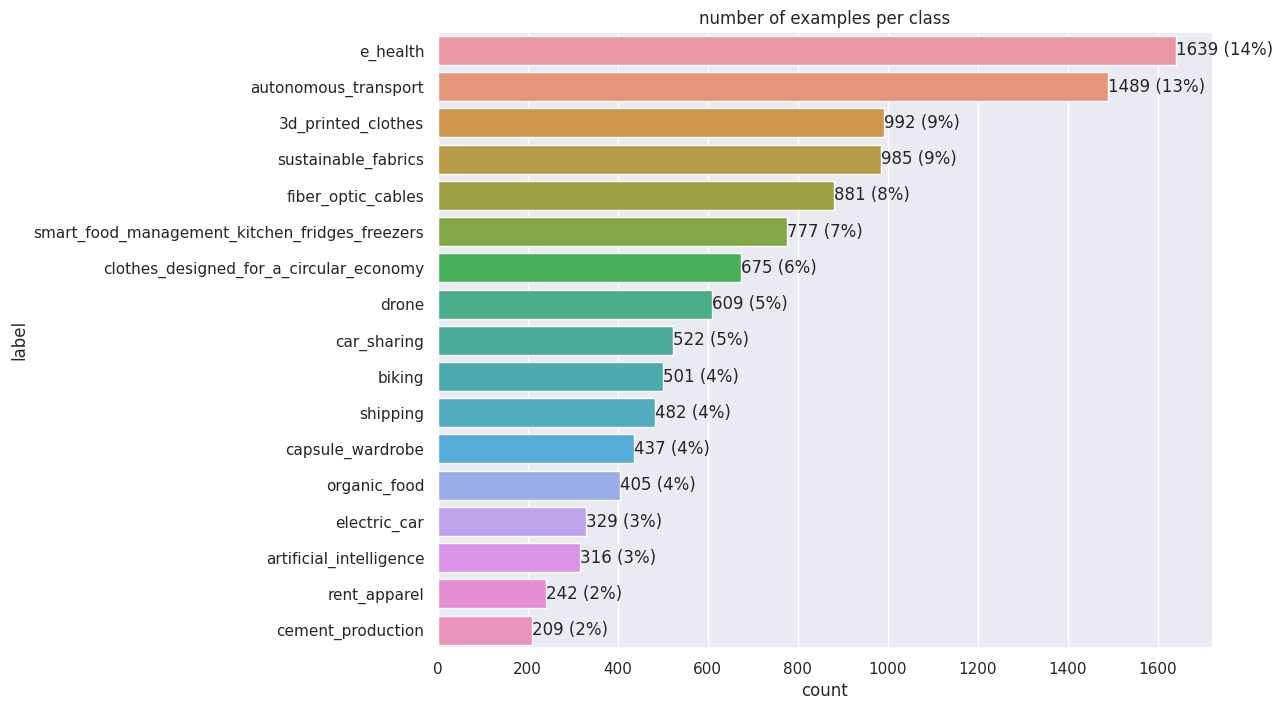

In [ ]:
plt.figure(figsize=(10,8))

abs_values = df['label'].value_counts(ascending=False)
g = sns.countplot(data=df, y="label", order=abs_values.index)
rel_values = df['label'].value_counts(ascending=False, normalize=True).values * 100
bar_labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values.values, rel_values)]
g.bar_label(container=g.containers[0], labels=bar_labels)
g.set_title("number of examples per class")

text length statistics


,mean,median,min,max
label,,,,
3d_printed_clothes,383.121976,380.5,57,1054
artificial_intelligence,470.534810,458.0,184,952
autonomous_transport,415.642042,403.0,14,2315
biking,419.335329,409.0,112,1187
capsule_wardrobe,358.945080,321.0,73,1189
car_sharing,318.021073,311.0,16,848
cement_production,450.602871,439.0,35,1119
clothes_designed_for_a_circular_economy,432.047407,414.0,123,1195
drone,410.180624,412.0,16,1655


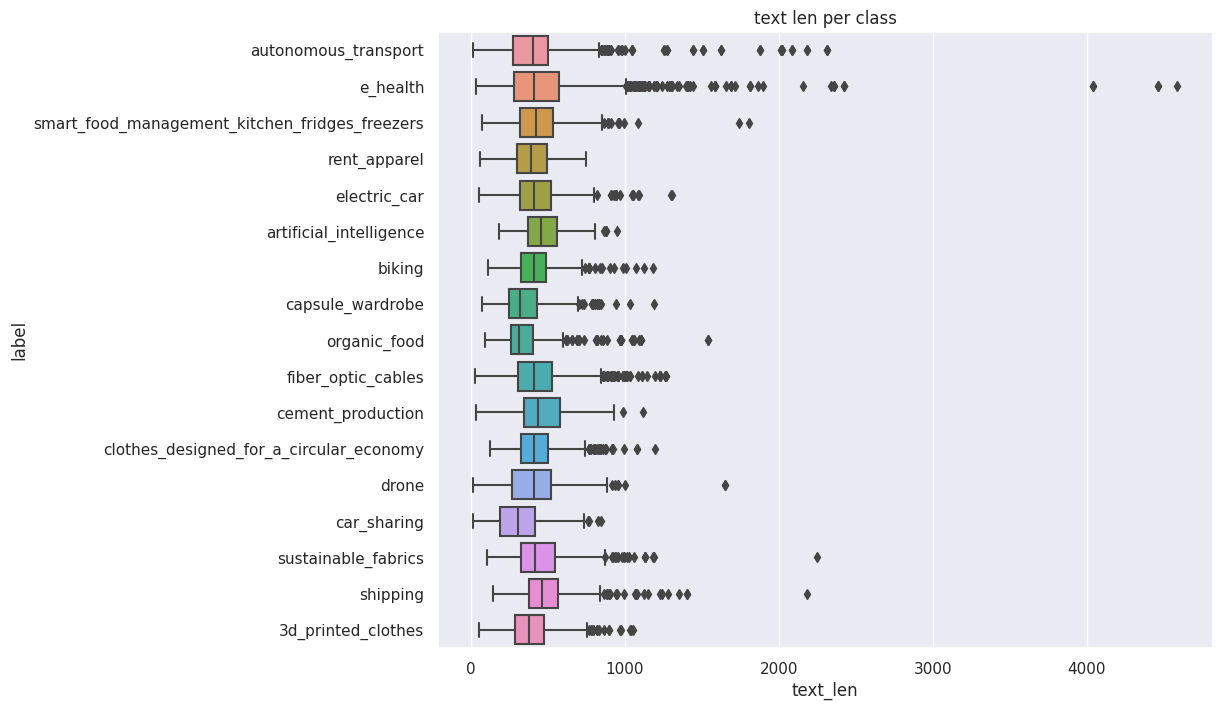

In [ ]:
df["text_len"] = df[["text"]].apply(lambda x:len(x.item()), axis=1)
plt.figure(figsize=(10,8))
g = sns.boxplot(data=df, x="text_len", y="label")
g.set_title("text len per class")
print("text length statistics")
df.groupby(["label"])["text_len"].agg(["mean","median","min","max"])

# Data Preparation
## Encode Labels

In [ ]:
le = preprocessing.LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

## Train, Valdiation and Test Split

In [ ]:
# 70, 20, 10 split
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [ ]:
# collect spans from the training data-set
new_spans = set(itertools.chain.from_iterable(train_df.spans.tolist()))

# Create Datasets and Tokenize

In [ ]:
# add new spans to the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=False)
# extend tokenizer with domain spans
new_tokens = set(new_spans) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(new_tokens))

246

In [ ]:
# define PyTorch dataset
class TAndIDataSet(Dataset):
    def __init__(self, text_column, encoded_labels):
        self.texts = text_column
        self.encodings = tokenizer(text_column.tolist(), truncation=True, padding=True, max_length=512)
        self.labels = encoded_labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item, self.texts[idx]

    def __len__(self):
        return len(self.labels)

In [ ]:
# create datasets
train_dataset = TAndIDataSet(train_df.text, train_df.label_encoded)
val_dataset = TAndIDataSet(val_df.text, val_df.label_encoded)
test_dataset = TAndIDataSet(test_df.text, test_df.label_encoded)
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader =  DataLoader(test_dataset, batch_size=32)

# Finetuning
## Definitions

In [ ]:
if train_model:
    # model definition
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(le.classes_)
    ).to("cuda")
    # adjust embeddings size for new vocabulary length
    model.resize_token_embeddings(len(tokenizer))
else:
    tokenizer = AutoTokenizer.from_pretrained(f"./{save_model_dir_name}", local_files_only=True)
    model = DistilBertForSequenceClassification.from_pretrained(f"./{save_model_dir_name}", local_files_only=True).to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# epochs
num_epochs = 10
# learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader)
)

## Training Loop

In [ ]:
if train_model:
    training_stats = []
    progress_bar = tqdm(range(num_epochs*(len(train_dataloader)+len(val_dataloader))))
    for epoch in range(num_epochs):
        print(f"\nRunning Epoch {epoch+1}/{num_epochs}...")
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_train_correct = 0
        epoch_val_correct = 0
        best_val_loss = np.Inf
        # training loop
        model.train()
        for batch, _ in train_dataloader:
            # move batch to gpu
            batch = {k: v.to("cuda") for k, v in batch.items()}
            # forward pass
            output = model(**batch)
            predictions = torch.argmax(output.logits, dim=-1)
            epoch_train_correct += (predictions == batch["labels"].flatten()).long().sum()
            # compute loss & backprop
            loss = output.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            # reset optimizer
            optimizer.zero_grad()
            # save batch_loss
            epoch_train_losses.append(loss.item())
            progress_bar.update(1)
        # validation loop
        model.eval()
        for batch, _ in val_dataloader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            with torch.no_grad():
                output = model(**batch)
                predictions = torch.argmax(output.logits, dim=-1)
                epoch_val_correct += (predictions == batch["labels"].flatten()).long().sum()
                epoch_val_losses.append(output.loss.item())
            progress_bar.update(1)
        # save epoch metrics
        epoch_stats = {
            "epoch":epoch,
            "train_loss":np.mean(epoch_train_losses),
            "val_loss":np.mean(epoch_val_losses),
            "train_accuracy":epoch_train_correct.item()/len(train_dataset),
            "val_accuracy":epoch_val_correct.item()/len(val_dataset)
        }
        print(epoch_stats)
        # save best model
        if np.mean(epoch_val_losses) < best_val_loss:
            model_path = f"./{save_model_dir_name}"
            model.save_pretrained(model_path)
            tokenizer.save_pretrained(model_path)
            best_val_loss = np.mean(epoch_val_losses)
        training_stats.append(epoch_stats)
    # if colab make sure to save best model to google drive
    training_stats = pd.DataFrame(training_stats)
    if colab:
        !cp -r $save_model_dir_name /content/drive/MyDrive
else:
    print("training disabled")

  0%|          | 0/5750 [00:00<?, ?it/s]


Running Epoch 1/10...
{'epoch': 0, 'train_loss': 0.6960361204656289, 'val_loss': 0.25246283704311484, 'train_accuracy': 0.8236757025615519, 'val_accuracy': 0.9282296650717703}

Running Epoch 2/10...
{'epoch': 1, 'train_loss': 0.1469884844409824, 'val_loss': 0.15482431494941315, 'train_accuracy': 0.9575976125341955, 'val_accuracy': 0.9534580252283602}

Running Epoch 3/10...
{'epoch': 2, 'train_loss': 0.04905618300798458, 'val_loss': 0.12936159266973846, 'train_accuracy': 0.9863218104949018, 'val_accuracy': 0.9621574597651152}

Running Epoch 4/10...
{'epoch': 3, 'train_loss': 0.020685811268089795, 'val_loss': 0.11535962296410515, 'train_accuracy': 0.9942800298433225, 'val_accuracy': 0.9691170073945193}

Running Epoch 5/10...
{'epoch': 4, 'train_loss': 0.015230409686905415, 'val_loss': 0.15177739193232911, 'train_accuracy': 0.9952748072618751, 'val_accuracy': 0.9656372335798173}

Running Epoch 6/10...
{'epoch': 5, 'train_loss': 0.009769794206800603, 'val_loss': 0.16397455016299822, 'trai

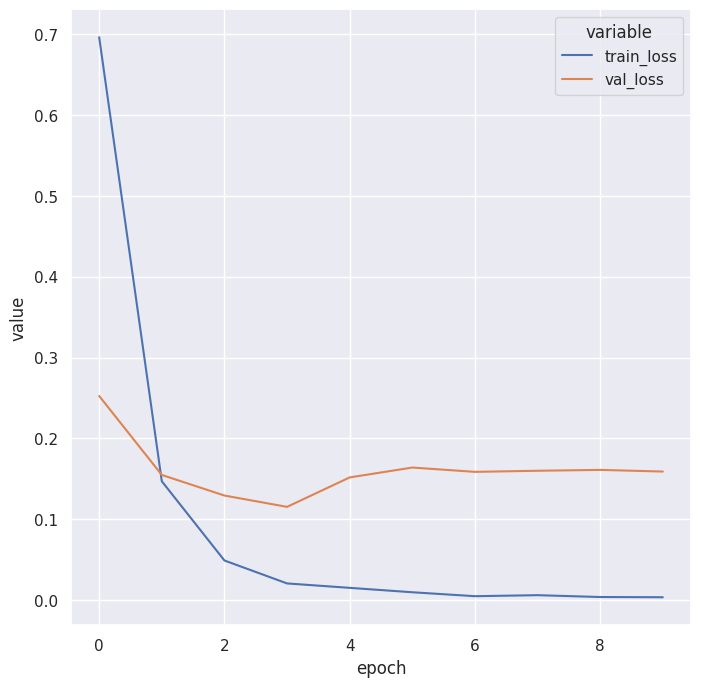

In [ ]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_loss","val_loss"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

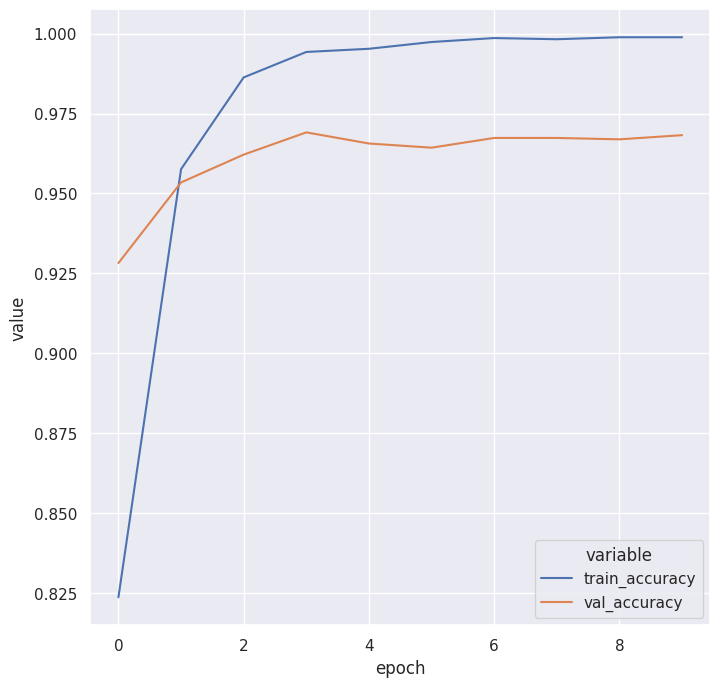

In [ ]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_accuracy","val_accuracy"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

# Testing

In [ ]:
progress_bar = tqdm(range(len(test_dataloader)))
test_correct = 0
test_predictions = []
model.eval()
for batch, texts in test_dataloader:
    batch = {k: v.to("cuda") for k, v in batch.items()}
    with torch.no_grad():
        output = model(**batch)
        local_predictions = torch.argmax(output.logits, dim=-1)
        top_k_predictions = torch.topk(output.logits, k=5)
        test_correct += (local_predictions == batch["labels"].flatten()).long().sum()
        for idx, pred in enumerate(local_predictions.tolist()):
            test_predictions.append({
                "y_hat_enc":pred,
                "y_enc":batch["labels"].flatten().tolist()[idx],
                "text":texts[idx],
                "top_k":top_k_predictions.indices[idx].tolist(),
                "in_top_k":batch["labels"].flatten().tolist()[idx] in top_k_predictions.indices[idx].tolist()
            })
    progress_bar.update(1)
print(f"Test Accuracy: {test_correct/(len(test_dataloader)*test_dataloader.batch_size)}")
test_predictions = pd.DataFrame(test_predictions)
test_predictions["y"] = le.inverse_transform(test_predictions["y_enc"])
test_predictions["y_hat"] = le.inverse_transform(test_predictions["y_hat_enc"])
print(f"Test top-k Accuracy: {len(test_predictions.loc[test_predictions.in_top_k])/(len(test_dataloader)*test_dataloader.batch_size)}")

  0%|          | 0/36 [00:00<?, ?it/s]

Test Accuracy: 0.9652777910232544
Test top-k Accuracy: 0.9956597222222222


## Wrong classifications

In [ ]:
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].head(n=1000)

In [ ]:
print("num. miss-classifications per class")
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].groupby(["y"])["y"].count()

Text(0.5, 72.98437499999999, 'y_hat')

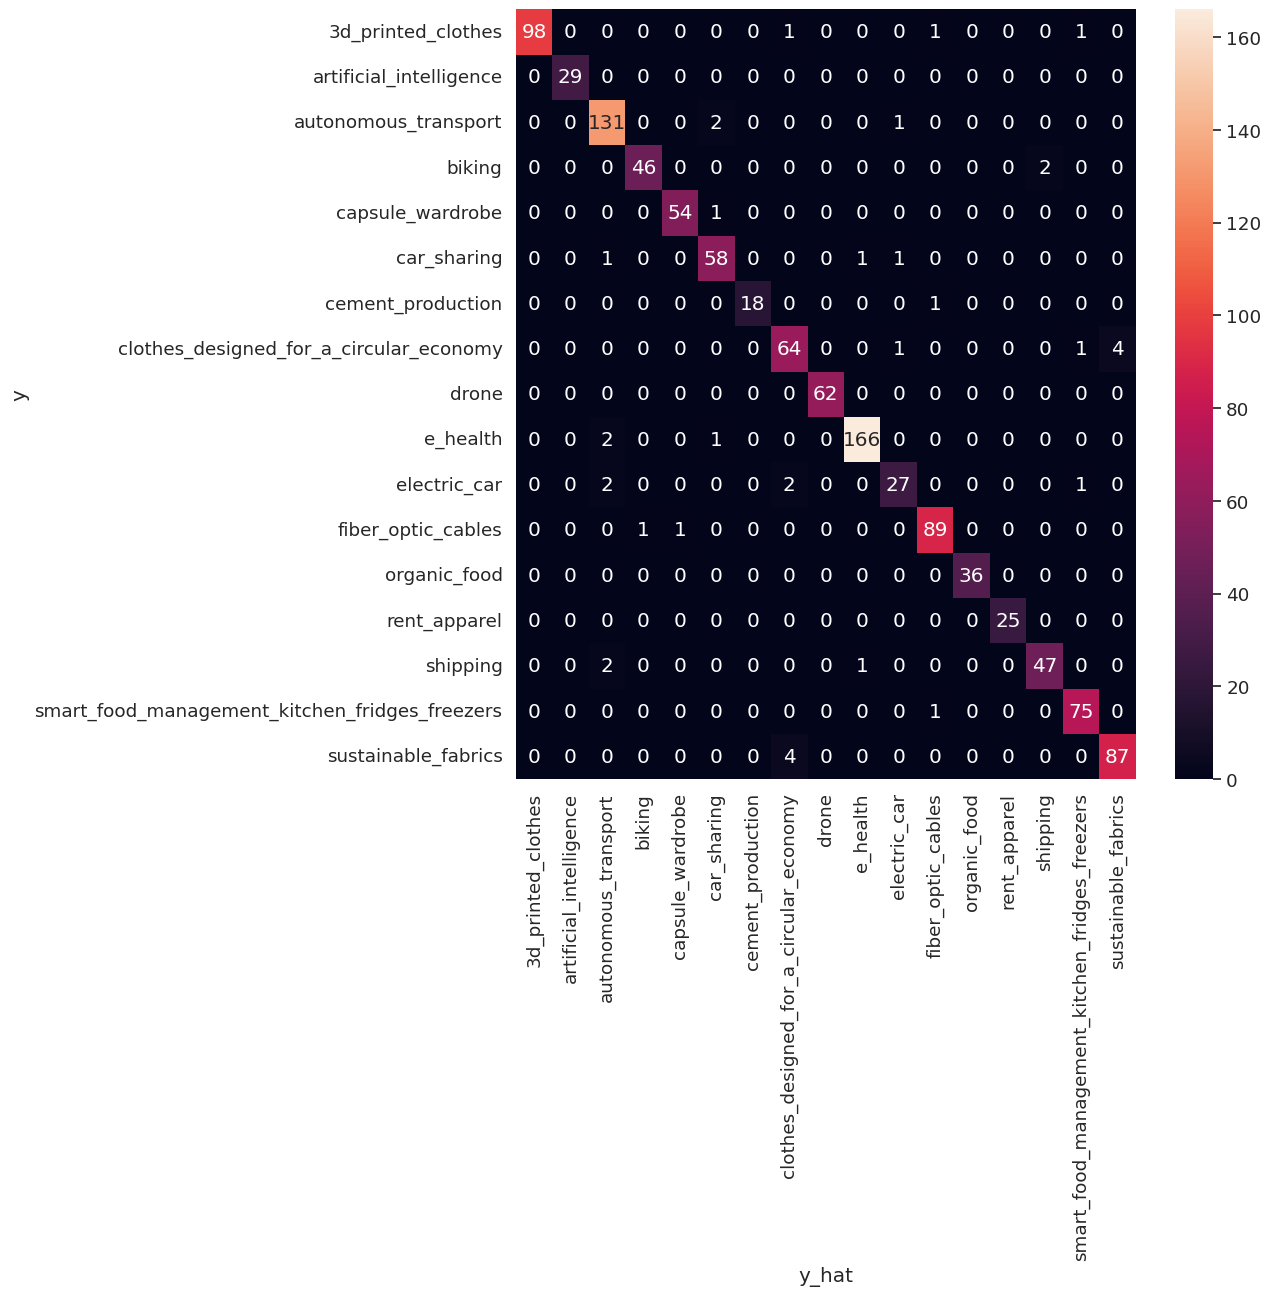

In [ ]:
axis_ticks = le.inverse_transform(list(range(0,17)))
cm = confusion_matrix(test_predictions["y_enc"],test_predictions["y_hat_enc"])
plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
g = sns.heatmap(cm, annot=True, fmt='g', yticklabels=axis_ticks, xticklabels=axis_ticks)
g.set_ylabel("y")
g.set_xlabel("y_hat")

## Inspecting text of non top-k correct classifications

In [ ]:
non_top_k = test_predictions.loc[~test_predictions.in_top_k]
axis_ticks = le.inverse_transform(list(set(list(non_top_k.y_hat_enc.unique()) + list(non_top_k.y_enc.unique()))))
cm = confusion_matrix(non_top_k["y_enc"],non_top_k["y_hat_enc"])
plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
g = sns.heatmap(cm, annot=True, fmt='g', yticklabels=axis_ticks, xticklabels=axis_ticks)
g.set_ylabel("y")
g.set_xlabel("y_hat")

In [ ]:
for idx, row in non_top_k.sort_values(by=['y']).iterrows():
    print(f"[{idx}]")
    print(f"class: {row.y}, predicted: {row.y_hat}")
    print(row.text)
    print("--------------")

[278]
class: electric_car, predicted: smart_food_management_kitchen_fridges_freezers
We’ll provide a workspace, specialty tools, and volunteer Fixit Coaches to help you troubleshoot and provide routine maintenance to your household items and appliances! Virtual Fixit Clinic
As COVID-19 unfolds Fixit Clinic is experimenting with “virtual” clinics using teleconferencing software. If you want to try fixing something from home and think remote advice and coaching would be helpful answer these questions:
- Do you have a computer and internet connection that will support video teleconferencing?
--------------
[660]
class: shipping, predicted: autonomous_transport
IMO's Technical Cooperation Committee has formally approved linkages between the Organization's technical assistance work and the SDGs. While SDG 14 is central to IMO, aspects of the Organization's work can be linked to all individual SDGs. 
--------------
[278]
class: electric_car, predicted: smart_food_management_kitchen_fridges_f